In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Data Preparation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV
import joblib 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from catboost import CatBoostRegressor


import warnings
warnings.filterwarnings("ignore")

In [6]:
train_df = pd.read_csv('../data/raw/sales_train.csv')
test_df = pd.read_csv('../data/raw/sales_test.csv')
price_per_week = pd.read_csv('../data/raw/items_weekly_sell_prices.csv')
calendar = pd.read_csv('../data/raw/calendar.csv')
calendar_events = pd.read_csv('../data/raw/calendar_events.csv')

In [7]:
test_df.head()

,d_1542,d_1543,d_1544,d_1545,d_1546,d_1547,d_1548,d_1549,d_1550,d_1551,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,0,1,0,2,1,0,2,0,1,0,...,2,4,0,0,0,0,3,3,0,1
1,0,0,0,0,0,0,0,0,1,0,...,0,1,2,1,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,4,1,0,1,3,5,2,3,0,2,...,1,1,0,4,0,1,3,0,2,6
4,3,0,0,1,1,0,2,0,2,1,...,0,0,0,2,1,0,0,2,1,0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1547 entries, id to d_1541
dtypes: int64(1541), object(6)
memory usage: 359.9+ MB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 400 entries, d_1542 to d_1941
dtypes: int64(400)
memory usage: 93.0 MB


In [10]:
price_per_week.head(10)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
5,CA_1,HOBBIES_1_001,11330,8.26
6,CA_1,HOBBIES_1_001,11331,8.26
7,CA_1,HOBBIES_1_001,11332,8.26
8,CA_1,HOBBIES_1_001,11333,8.26
9,CA_1,HOBBIES_1_001,11334,8.26


In [11]:
price_per_week.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [12]:
calendar.head(14)

,date,wm_yr_wk,d
0,2011-01-29,11101,d_1
1,2011-01-30,11101,d_2
2,2011-01-31,11101,d_3
3,2011-02-01,11101,d_4
4,2011-02-02,11101,d_5
5,2011-02-03,11101,d_6
6,2011-02-04,11101,d_7
7,2011-02-05,11102,d_8
8,2011-02-06,11102,d_9
9,2011-02-07,11102,d_10


In [13]:
calendar_events.head()

,date,event_name,event_type
0,2011-02-06,SuperBowl,Sporting
1,2011-02-14,ValentinesDay,Cultural
2,2011-02-21,PresidentsDay,National
3,2011-03-09,LentStart,Religious
4,2011-03-16,LentWeek2,Religious


In [14]:
print(train_df["item_id"].unique())
print(train_df["store_id"].unique())
print(train_df["cat_id"].unique())
print(train_df["state_id"].unique())

['HOBBIES_1_001' 'HOBBIES_1_002' 'HOBBIES_1_003' ... 'FOODS_3_825'
 'FOODS_3_826' 'FOODS_3_827']
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
['HOBBIES' 'HOUSEHOLD' 'FOODS']
['CA' 'TX' 'WI']


## 2. Feature Engineering 

In [15]:
test_df = pd.merge(train_df.iloc[:, :6], test_df, left_index=True, right_index=True )

In [16]:
df_train_melted = pd.melt(train_df, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'd', value_name = "sales")

In [17]:
df_test_melted = pd.melt(test_df, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'd', value_name = "sales")

In [18]:
calendar = calendar.merge(calendar_events, on= "date", how='left')
calendar

,date,wm_yr_wk,d,event_name,event_type
0,2011-01-29,11101,d_1,NaN,NaN
1,2011-01-30,11101,d_2,NaN,NaN
2,2011-01-31,11101,d_3,NaN,NaN
3,2011-02-01,11101,d_4,NaN,NaN
4,2011-02-02,11101,d_5,NaN,NaN
...,...,...,...,...,...
1969,2016-06-16,11620,d_1966,NaN,NaN
1970,2016-06-17,11620,d_1967,NaN,NaN
1971,2016-06-18,11621,d_1968,NaN,NaN
1972,2016-06-19,11621,d_1969,Father's day,Cultural


In [19]:
df_train = pd.merge(df_train_melted, calendar, on = "d")
df_test = pd.merge(df_test_melted, calendar, on = "d")

In [20]:
df_train = pd.merge(df_train, price_per_week, on=['store_id','item_id','wm_yr_wk'], how='left') 
df_train

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,event_name,event_type,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47107045,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1541,2,2015-04-18,11512,NaN,NaN,2.88
47107046,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1541,0,2015-04-18,11512,NaN,NaN,2.00
47107047,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1541,0,2015-04-18,11512,NaN,NaN,3.98
47107048,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1541,0,2015-04-18,11512,NaN,NaN,1.28


In [21]:
df_test = pd.merge(df_test, price_per_week, on=['store_id','item_id','wm_yr_wk'], how='left') 
df_test

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,event_name,event_type,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1542,0,2015-04-19,11512,NaN,NaN,8.26
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1542,0,2015-04-19,11512,NaN,NaN,3.97
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1542,0,2015-04-19,11512,NaN,NaN,2.97
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1542,4,2015-04-19,11512,NaN,NaN,4.64
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1542,3,2015-04-19,11512,NaN,NaN,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12195995,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1,2016-05-22,11617,NaN,NaN,2.98
12195996,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,NaN,NaN,2.48
12195997,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2,2016-05-22,11617,NaN,NaN,3.98
12195998,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,NaN,NaN,1.28


In [22]:
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)


In [23]:
def preprocess_data(df):
    df["revenues"] = df["sales"] * df["sell_price"]
    df["is_event"] = df["event_type"].apply(lambda x: 0 if x == 0 else 1)
    df["day_of_week"] = pd.to_datetime(df['date']).dt.dayofweek
    df["year"] = pd.to_datetime(df['date']).dt.year
    df["month"] = pd.to_datetime(df['date']).dt.month
    df['day'] = pd.to_datetime(df['date']).dt.day
    return df

In [25]:

preprocess_data(df_train)
preprocess_data(df_test)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,event_name,event_type,sell_price,revenues,is_event,day_of_week,year,month,day
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1542,0,2015-04-19,11512,0,0,8.26,0.00,0,6,2015,4,19
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1542,0,2015-04-19,11512,0,0,3.97,0.00,0,6,2015,4,19
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1542,0,2015-04-19,11512,0,0,2.97,0.00,0,6,2015,4,19
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1542,4,2015-04-19,11512,0,0,4.64,18.56,0,6,2015,4,19
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1542,3,2015-04-19,11512,0,0,2.88,8.64,0,6,2015,4,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12195995,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1,2016-05-22,11617,0,0,2.98,2.98,0,6,2016,5,22
12195996,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,0,0,2.48,0.00,0,6,2016,5,22
12195997,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2,2016-05-22,11617,0,0,3.98,7.96,0,6,2016,5,22
12195998,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,0,0,1.28,0.00,0,6,2016,5,22


## 3. Exploratory Data Analysis

In [26]:
total_revenues = df_train.groupby(["cat_id", "dept_id"])['revenues'].sum().reset_index()
total_sales = df_train.groupby(["cat_id", "dept_id"])['sales'].sum().reset_index()
avg_price = df_train.groupby(["cat_id", "dept_id"])['sell_price'].mean().reset_index()

In [27]:
def bar_department(total_revenues, total_sales, avg_price):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    width = 0.25
    x = np.arange(len(total_revenues["dept_id"]))

    # Plot the first graph (Total Revenues)
    axes[0].bar(x, total_revenues["revenues"], width, color='b', label='Total Revenues')
    axes[0].set_title("Total Revenues across Departments", fontsize=15)
    axes[0].set_ylabel("Revenues", fontsize=13)
    axes[0].set_xlabel("Department", fontsize=13)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(total_revenues["dept_id"], rotation=90)
    axes[0].legend()

    # Plot the second graph (Total Sales)
    axes[1].bar(x, total_sales["sales"], width, color='g', label='Total Sales')
    axes[1].set_title("Total Sales across Departments", fontsize=15)
    axes[1].set_ylabel("Sales", fontsize=13)
    axes[1].set_xlabel("Department", fontsize=13)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(total_sales["dept_id"], rotation=90)
    axes[1].legend()

    # Plot the third graph (Average Price)
    axes[2].bar(x, avg_price["sell_price"], width, color='r', label='Average Price')
    axes[2].set_title("Average Price across Departments", fontsize=15)
    axes[2].set_ylabel("Avg Price", fontsize=13)
    axes[2].set_xlabel("Department", fontsize=13)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(avg_price["dept_id"], rotation=90)
    axes[2].legend()

    # Adjust the layout to avoid overlapping
    plt.tight_layout()

    # Show the subplots
    plt.show()

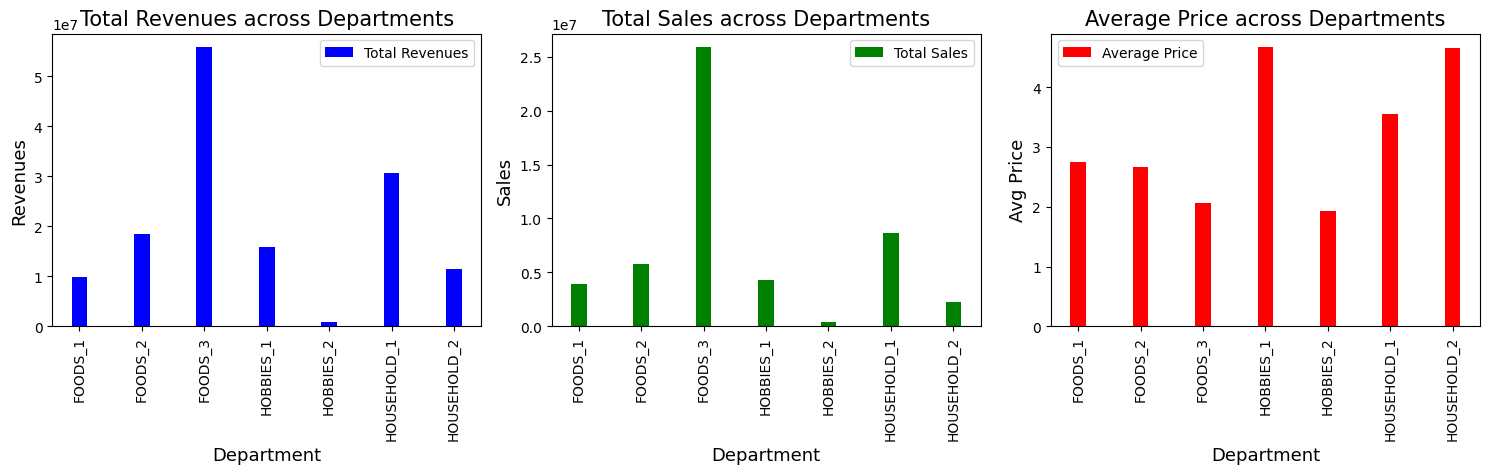

In [28]:

bar_department(total_revenues, total_sales, avg_price)

In [29]:
import random
def revenue(feat, param):
    revenues_df = df_train.loc[df_train[feat] == param]
    revenues_df['date'] = pd.to_datetime(revenues_df['date'])
    revenues_df = revenues_df.groupby('date')['revenues'].sum().reset_index()
    revenues_df = revenues_df.set_index('date')
    return revenues_df

def color():
    colors = ["blue","black","brown","red","yellow","green","orange"]
    random.shuffle(colors)
    return colors[0]

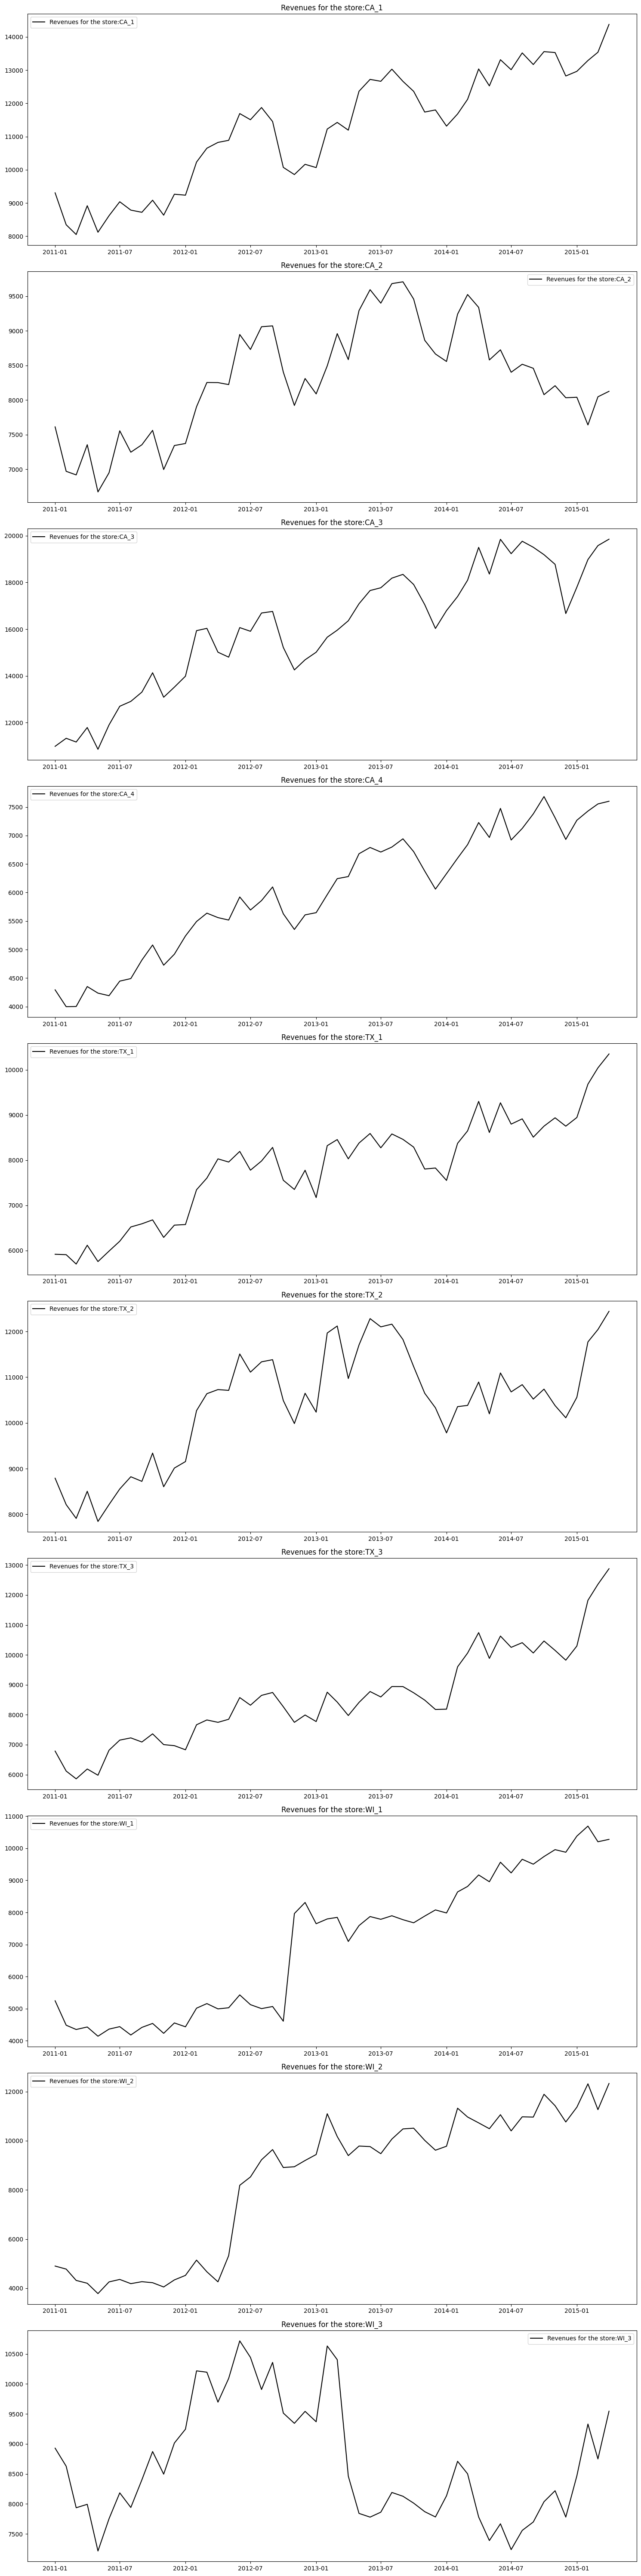

In [30]:
store_ids = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']

# Create subplots
fig, axes = plt.subplots(len(store_ids), 1, figsize=(15, 6*len(store_ids)))
colour = color()

# Loop through each store ID and create line plots
for i, store_id in enumerate(store_ids):
    store_data = revenue("store_id", store_id)
    y_store = store_data['revenues'].resample('MS').mean()
    
    # Plot the data on the corresponding subplot
    axes[i].plot(y_store, label=f"Revenues for the store:{store_id}", color=colour)
    axes[i].set_title(f"Revenues for the store:{store_id}")
    axes[i].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

## 4. Columns Transformer

In [31]:
df_train = df_train[['item_id', 'store_id', 'year', 'month', 'day', 'day_of_week', 'revenues']]
df_test = df_test[['item_id', 'store_id', 'year', 'month', 'day', 'day_of_week', 'revenues']]

In [32]:
df_train = df_train.loc[df_train['revenues'] != 0]
df_test = df_test.loc[df_test['revenues'] != 0]

In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14023073 entries, 7 to 47107049
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   item_id      object 
 1   store_id     object 
 2   year         int32  
 3   month        int32  
 4   day          int32  
 5   day_of_week  int32  
 6   revenues     float64
dtypes: float64(1), int32(4), object(2)
memory usage: 641.9+ MB


In [34]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4954566 entries, 3 to 12195999
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   item_id      object 
 1   store_id     object 
 2   year         int32  
 3   month        int32  
 4   day          int32  
 5   day_of_week  int32  
 6   revenues     float64
dtypes: float64(1), int32(4), object(2)
memory usage: 226.8+ MB


In [35]:
def create_transformer(num_cols, cat_cols):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', num_cols), 
            ('cat', OneHotEncoder(), cat_cols)
        ])
    return preprocessor

In [36]:
num_cols = ['year', 'month', 'day', 'day_of_week']
cat_cols = ['item_id', 'store_id']

preprocessor = create_transformer(num_cols, cat_cols)

## 5. Train Default CatBoost Regressor Model

In [37]:
X_train = df_train.drop(['revenues'], axis=1)
y_train = df_train['revenues']

In [38]:
X_test = df_test.drop(['revenues'], axis=1)
y_test = df_test['revenues']

In [39]:
def create_cat_boost_pipeline(preprocessor, X_train, y_train):
    cat_pipe = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('cat', CatBoostRegressor())
        ]
    )
    cat_pipe.fit(X_train, y_train)
    joblib.dump(cat_pipe, '../models/cat_pipe.pkl')
    return cat_pipe

In [40]:

cat_pipe = create_cat_boost_pipeline(preprocessor, X_train, y_train)

Learning rate set to 0.185089
0:	learn: 14.0944503	total: 1.73s	remaining: 28m 49s
1:	learn: 13.8279873	total: 2.78s	remaining: 23m 6s
2:	learn: 13.6361842	total: 3.84s	remaining: 21m 17s
3:	learn: 13.4969328	total: 4.8s	remaining: 19m 54s
4:	learn: 13.3848888	total: 5.75s	remaining: 19m 5s
5:	learn: 13.2972743	total: 6.65s	remaining: 18m 21s
6:	learn: 13.2135386	total: 7.55s	remaining: 17m 51s
7:	learn: 13.1432043	total: 8.44s	remaining: 17m 26s
8:	learn: 13.0760556	total: 9.29s	remaining: 17m 3s
9:	learn: 13.0164319	total: 10.1s	remaining: 16m 39s
10:	learn: 12.9578853	total: 10.9s	remaining: 16m 22s
11:	learn: 12.8865512	total: 11.8s	remaining: 16m 7s
12:	learn: 12.8295317	total: 12.6s	remaining: 15m 53s
13:	learn: 12.7823545	total: 13.4s	remaining: 15m 42s
14:	learn: 12.7395972	total: 14.2s	remaining: 15m 31s
15:	learn: 12.6988994	total: 15s	remaining: 15m 23s
16:	learn: 12.6560580	total: 15.8s	remaining: 15m 14s
17:	learn: 12.6131377	total: 16.6s	remaining: 15m 8s
18:	learn: 12.56

In [41]:
pred_1 = cat_pipe.predict(X_test)

In [42]:
def calculate_regression_metrics(y_test, pred):
    rmse = mean_squared_error(y_test, pred, squared=False)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    metrics = {
        "RMSE": rmse,
        "MSE": mse,
        "R2": r2,
        "MAE": mae
    }
    return metrics

In [43]:
calculate_regression_metrics(y_test, pred_1)

{'RMSE': 9.952729766102328,
 'MSE': 99.05682979705931,
 'R2': 0.6127921258090472,
 'MAE': 5.169240553358678}

In [44]:
df_pred = pd.DataFrame({'Actual Value (y_test)'    : y_test,
                              'Predicted Value (CatBoost)' : pred_1,
                              'Difference (Best Features)'      : abs(y_test - pred_1)})


df_pred    

,Actual Value (y_test),Predicted Value (CatBoost),Difference (Best Features)
3,18.56,13.420782,5.139218
4,8.64,8.927815,0.287815
5,2.00,7.073252,5.073252
6,7.88,8.927815,1.047815
7,1.92,7.084395,5.164395
...,...,...,...
12195993,19.92,5.922616,13.997384
12195994,15.92,13.057642,2.862358
12195995,2.98,5.922616,2.942616
12195997,7.96,5.922616,2.037384


## 6. Train Optimal Catboost Regressor with tuned hyperparameters

In [45]:
def create_cat_pipe_tuned(preprocessor, X_train, y_train):
    cat_pipe_tuned = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('cat', CatBoostRegressor(
                n_estimators=400,  # Number of boosting rounds 
                learning_rate=0.1,  # Step size shrinkage
                max_depth=5,  # Maximum tree depth
                subsample=0.8,  # Fraction of samples used for each boosting round
                colsample_bytree=0.8,  # Fraction of features used for each boosting round
                min_child_weight=1,  # Minimum sum of instance weight in a child
                gamma=0  # Regularization parameter  
            ))
        ]
    )
    cat_pipe_tuned.fit(X_train, y_train)
    joblib.dump(cat_pipe, '../models/cat_pipe_tuned.pkl')
    return cat_pipe_tuned

In [46]:
cat_pipe_tuned = create_cat_pipe_tuned(preprocessor, X_train, y_train)

TypeError: CatBoostRegressor.__init__() got an unexpected keyword argument 'colsample_bytree'

In [ ]:
pred_2 = cat_pipe_tuned.predict(X_test)

In [ ]:
calculate_regression_metrics(y_test, pred_2)

{'RMSE': 10.76091538545974,
 'MSE': 115.79729993302414,
 'R2': 0.5473545192595137,
 'MAE': 5.950656518255698}

In [ ]:
df_pred_2 = pd.DataFrame({'Actual Value (y_test)'    : y_test,
                              'Predicted Value (Catboost_tuned)' : pred_2,
                              'Difference (Best Features)'      : abs(y_test - pred_2)})


df_pred_2

,Actual Value (y_test),Predicted Value (XGBOOST_tuned),Difference (Best Features)
3,18.56,9.964280,8.595720
4,8.64,9.205980,0.565980
5,2.00,9.205980,7.205980
6,7.88,9.205980,1.325980
7,1.92,9.205980,7.285980
...,...,...,...
12195993,19.92,8.757433,11.162567
12195994,15.92,10.581149,5.338851
12195995,2.98,8.757433,5.777433
12195997,7.96,8.757433,0.797433
